Based on 

https://mssanz.org.au/modsim2019/H7/sharples.pdf 

recent research into the structure and parsimony of empirical fire spread models used in Australia has shown that for a number of different fuels types, the output of operational rate of spread models can be accurately emulated using a very simple approach. In particular, it has been shown that a single functional model, defined by two independent parameters, can accurately reproduce operational rate of spread predictions in fuels such as grass, shrubland, dry eucalypt forest, buttongrass and semi-arid mallee-heath.

In [1]:
import dask
from dask.distributed import Client, wait
from dask import delayed

client = Client(n_workers=7, threads_per_worker=1) 
#client = Client()

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43905,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:32855,Total threads: 1
Dashboard: /proxy/45333/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:38027,


In [2]:
#import all the stuff
from netCDF4 import Dataset
import xarray as xr
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import glob
import sys
sys.path.append("/g/data/mn51/users/nb6195/project/gwls/")
import gwl

In [3]:
#function to calculate fuel moisture index
#inputs: datasets of temperature and relative humidity
#outputs: a dataset of rate of spread
def calc_fmi(ds_temp, ds_rh, chosen_gwl):
    fmi = 10 - 0.25*(ds_temp - ds_rh)

    fmi.attrs = {
        'long_name': 'sharples fuel moisture index',
        'standard_name': 'sfmi',
        'units': 'dimensionless',
        'program' : 'Australian Climate Service (ACS)',
        'summary' : f'Fire weather metric: sharples fuel moisture index for Global Warming Level {chosen_gwl} C',
        'naming_authority' : "Bureau of Meteorology",
        'publisher_type' : "group",
        'publisher_type' : "group" ,
        'publisher_institution' : "Bureau of Meteorology",
        'publisher_name' : "Bureau of Meteorology",
        'publisher_url' : "http://www.bom.gov.au",
        'creator_type' : "institution" ,
        'creator_institution' : "Bureau of Meteorology" ,
        'contact' : "Naomi Benger (naomi.benger@bom.gov.au)" ,
        'institute_id' : "BOM" ,
        'institution' : "Bureau of Meteorology",
#        'regrid_method': 'bilinear'
    }
    ds_fmi = xr.Dataset({'fmi' : fmi})
    ds_rh.close()
    ds_temp.close()
    
    return ds_fmi

In [4]:
#function to calculate rate of spread
#inputs: datasets of fuel moisture index and wind speed, scalers mu, p, alpha
#outputs: a dataset of fuel moisture index
def calc_sros(ds_fmi, ds_wind, mu, p, alpha, chosen_gwl):
    ds_wind_aug = np.where(ds_wind < 1/3.6, 1, ds_wind*3.6)
    sros = alpha*(ds_wind_aug/(ds_fmi + mu))**p

    sros.attrs = {
        'long_name': 'sharples rate of spread',
        'standard_name': 'sros',
        'units': 'km/h',
        'program' : 'Australian Climate Service (ACS)',
        'summary' : f'Fire weather metric: sharples rate of spread for Global Warming Level {chosen_gwl} C',
        'naming_authority' : "Bureau of Meteorology",
        'publisher_type' : "group",
        'publisher_type' : "group" ,
        'publisher_institution' : "Bureau of Meteorology",
        'publisher_name' : "Bureau of Meteorology",
        'publisher_url' : "http://www.bom.gov.au",
        'creator_type' : "institution" ,
        'creator_institution' : "Bureau of Meteorology" ,
        'contact' : "Naomi Benger (naomi.benger@bom.gov.au)" ,
        'institute_id' : "BOM" ,
        'institution' : "Bureau of Meteorology",
#        'regrid_method': 'bilinear'
    }
    ds_sros = xr.Dataset({'sros' : sros})
    ds_wind.close()
    
    return ds_sros

In [5]:
#Set parameters
CMIP='CMIP6'
#AGENCY = 'CSIRO' 
#RCM = 'CCAM-v2203-SN'
AGENCY = 'BOM' 
RCM = 'BARPA-R'

#GCM = 'ACCESS-CM2' #ensemble = 'r4i1p1f1' #Done
#GCM = 'ACCESS-ESM1-5' #ensemble = 'r6i1p1f1' #Done
#GCM = 'EC-Earth3' ensemble = 'r1i1p1f1' #Done
#GCM = 'MPI-ESM1-2-HR' ensemble = 'r1i1p1f1' #BOM done, no CSIRO
GCM = 'CESM2' 
ensemble = 'r11i1p1f1' #Done
#GCM = 'CMCC-ESM2' ensemble = 'r1i1p1f1' #Done
#GCM = 'NorESM2-MM' ensemble = 'r1i1p1f1' #Done
#GCM = 'CNRM-ESM2-1' ensemble = 'r1i1p1f2' #CSIRO Done, no BOM

#pathway = 'ssp126'
pathway = 'ssp370'

ddir = f"/g/data/kj66/CORDEX/output/{CMIP}/DD/AUST-05i/{AGENCY}/{GCM}"
output_dir = '/g/data/ia39/ncra/bushfire/grass/'

In [6]:
#read in RCM files
var1 = 'tasmax'
infiles1a=glob.glob(ddir+f'/historical/{ensemble}/{RCM}/v1-r1/day/{var1}/v20241216//{var1}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
infiles1b=glob.glob(ddir+f'/{pathway}/{ensemble}/{RCM}/v1-r1/day/{var1}/v20241216/{var1}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
tasmax_master_ds = xr.open_mfdataset(infiles1a + infiles1b)

In [7]:
var2 = 'hursmin'
infiles2a=glob.glob(ddir+f'/historical/{ensemble}/{RCM}/v1-r1/day/{var2}/v20241216/{var2}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
infiles2b=glob.glob(ddir+f'/{pathway}/{ensemble}/{RCM}/v1-r1/day/{var2}/v20241216/{var2}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
hursmin_master_ds = xr.open_mfdataset(infiles2a + infiles2b)

In [8]:
var3 = 'sfcWindmax'
infiles3a=glob.glob(ddir+f'/historical/{ensemble}/{RCM}/v1-r1/day/{var3}/v20241216/{var3}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
infiles3b=glob.glob(ddir+f'/{pathway}/{ensemble}/{RCM}/v1-r1/day/{var3}/v20241216/{var3}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
wind_sp_master_ds = xr.open_mfdataset(infiles3a + infiles3b)

In [9]:
#Extract time period corresponding to the chosen GWL for tasmax and rh
chosen_gwl = '1.2'

gwl_tasmax = gwl.get_GWL_timeslice(tasmax_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[var1]
gwl_rh = gwl.get_GWL_timeslice(hursmin_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[var2]
gwl_wind_sp = gwl.get_GWL_timeslice(wind_sp_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[var3]

In [10]:
#AFDRS grassland with curing 100% and natural grassland
#AFDRS buttongrass with tsf = 20
#AFDRS mallee-heath with cover 5% and overstory height 3m
#AFDRS shrubland with wind reduction factor 0.67 and av veg height 2m
#for AFDRS need the alpha values from the table in Jason's slides
##mu = 5
##p = 1
##alpha = 1

In [11]:
#Ponderosa pine/Douglas-fir (C-7 fuel type)
#needs to be converted to a quadratic for the full calc
#mu = 5.39
#p = 1.98
#alpha = 3.064

In [17]:
#trial
mu = 5
p = 1
alpha = 1

In [18]:
#CFBPS O-1 fuel type rate of spread model using least squares regression (minimising the RMS difference)
#mu = 1.84
#p = 0.74
#alpha = 20.74

In [19]:
#function test status: calculation executes, array structure correct, attributes correct, ds output plots and looks reasonable.
gwl_fmi = calc_fmi(gwl_tasmax, gwl_rh, chosen_gwl)['fmi']

In [28]:
np.min(gwl_fmi)

<xarray.DataArray 'fmi' ()> Size: 4B
dask.array<_nanmin_skip-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

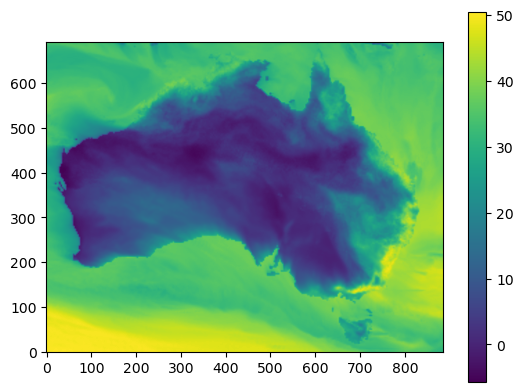

In [21]:
plt.imshow(gwl_fmi[10], origin='lower')
plt.colorbar()

In [22]:
#function test status: calculation executes, array structure correct, attributes correct, plotting won't work.
gwl_sros = calc_sros(gwl_fmi[0:19], gwl_wind_sp[0:19], mu, p, alpha, chosen_gwl)['sros']

In [23]:
gwl_sros

<xarray.DataArray 'sros' (time: 19, lat: 691, lon: 886)> Size: 47MB
dask.array<mul, shape=(19, 691, 886), dtype=float32, chunksize=(1, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 152B 2010-01-01 12:00:00 ... 2010-01-19 12:00:00
  * lat      (lat) float64 6kB -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
Attributes: (12/15)
    long_name:              sharples rate of spread
    standard_name:          sros
    units:                  km/h
    program:                Australian Climate Service (ACS)
    summary:                Fire weather metric: sharples rate of spread for ...
    naming_authority:       Bureau of Meteorology
    ...                     ...
    publisher_url:          http://www.bom.gov.au
    creator_type:           institution
    creator_institution:    Bureau of Meteorology
    contact:                Naomi Benger (naomi.benger@bom.gov.au)
    institute_id:           BOM
    institution:            Bureau of Meteorology

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 44.38 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)


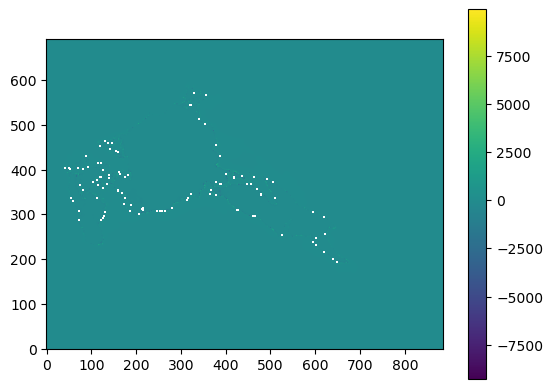

In [24]:
plt.imshow(gwl_sros[18], origin='lower')
plt.colorbar()

In [68]:
ds_wind_aug = np.where(gwl_wind_sp[0:19] < 1/3.6, 1, gwl_wind_sp[0:19]*3.6)

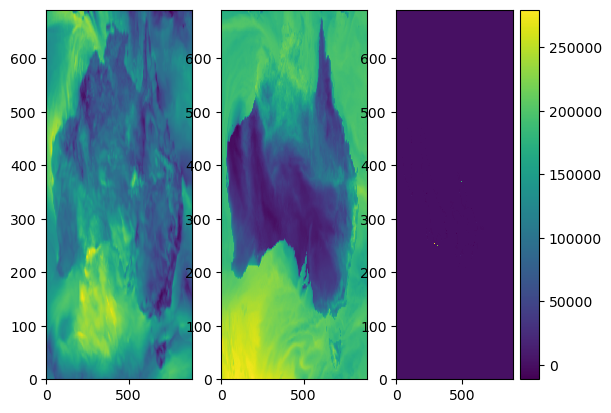

In [73]:
fh, axes = plt.subplots(ncols = 3)
axes[0].pcolormesh(ds_wind_aug[0])
axes[1].pcolormesh(gwl_fmi[0]+ mu)
ph=axes[2].pcolormesh(np.divide(ds_wind_aug[0], gwl_fmi[0]+ mu))
plt.colorbar(ph)

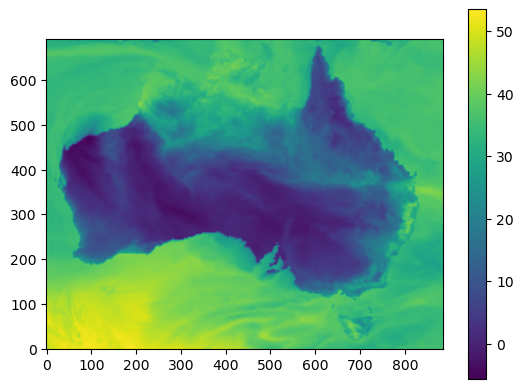

In [76]:
plt.imshow(gwl_fmi[0]+ mu, origin='lower')
plt.colorbar()

In [61]:
sros = alpha*(ds_wind_aug/(gwl_fmi[0:19] + mu))**p

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 44.38 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


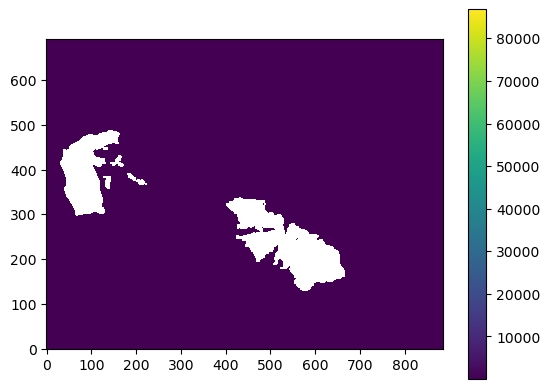

In [63]:
plt.imshow(sros[1], origin='lower')
plt.colorbar()